In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSJWQS9/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSJWQS9/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


def downsample_block(x, n_filters, POOLING_TYPE, DROPOUT_RATE):
  f = double_conv_block(x, n_filters)
  
  if POOLING_TYPE == 'MP':
    p = layers.AveragePooling2D(2)(f)

  elif POOLING_TYPE == 'AP':
    p = layers.AveragePooling2D(2)(f)
  g = layers.Dropout(DROPOUT_RATE)(p)

  return f,g


def upsample_block(x, conv_features, n_filters, DROPOUT_RATE):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(DROPOUT_RATE)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE):
  unet_model = build_unet_model()
  unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                    loss="sparse_categorical_crossentropy",
                    metrics="accuracy")
  
  TRAIN_LENGTH = info.splits["train"].num_examples
  STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

  VAL_SUBSPLITS = 5
  TEST_LENTH = info.splits["test"].num_examples
  VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

  model_history = unet_model.fit(train_batches,
                                epochs=EPOCHS,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_steps=VALIDATION_STEPS,
                                validation_data=test_batches)
  return model_history

In [ ]:
def build_unet_model(): # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64, POOLING_TYPE, DROPOUT_RATE)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128, POOLING_TYPE, DROPOUT_RATE)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256, POOLING_TYPE, DROPOUT_RATE)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512, POOLING_TYPE, DROPOUT_RATE)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512, DROPOUT_RATE)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256, DROPOUT_RATE)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128, DROPOUT_RATE)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64, DROPOUT_RATE)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

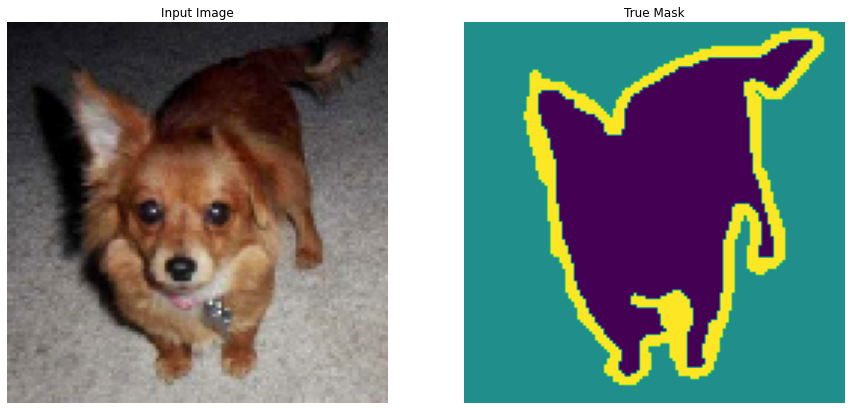

In [ ]:
LEARNING_RATE = .001
EPOCHS = 2
BATCH_SIZE = 64
POOLING_TYPE = 'MP' 
DROPOUT_RATE = .3

train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
dim = 5
gy_size = 5
gc_size = 3
max_gen = 5

limit = round(0.2 * dim * gy_size)

lr_min = 0.001
lr_max = 0.1

epochs_min = 1
epochs_max = 11

batchsize_data = [32,64,128,256]

poolingtype = ['MP', 'AP']

dr_min = 0.001
dr_max = 0.1

L = np.zeros(gy_size)
generation = 1


In [ ]:
LearningRate = []
Epochs = []
DropoutRate = []
BatchSize = []
PoolingType = []

record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []


for i in range(gy_size):
  LearningRate.append((lr_max-lr_min)*random.random())
  Epochs.append(round((epochs_max-epochs_min)*random.random()))
  DropoutRate.append((dr_max-dr_min)*random.random())
  BatchSize.append(int(np.array(random.sample(batchsize_data,1))))
  PoolingType.append("".join(random.sample(poolingtype,1)))

LearningRate_ori = LearningRate
Epochs_ori = Epochs
DropoutRate_ori = DropoutRate
BatchSize_ori = BatchSize
PoolingType_ori = PoolingType

accuracy = []
for i in range(gy_size):
  LEARNING_RATE = LearningRate[i]
  EPOCHS = Epochs[i]
  DROPOUT_RATE = DropoutRate[i]
  BATCH_SIZE = BatchSize[i]
  POOLING_TYPE = PoolingType[i]
  model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)
  # print(model_history.history)
  if model_history.history:
    temp = model_history.history['accuracy'][-1]
  else:
    temp = 1
  accuracy.append(temp)

maxacc = max(accuracy)
idx_max = int(np.argwhere(np.array(accuracy) == max(accuracy))[0])
accuracy_ori = accuracy

Epoch 1/6
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3058WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 118s 835ms/step - loss: nan - accuracy: 0.3058 - val_loss: nan - val_accuracy: 0.2935
Epoch 2/6
115/115 [==============================] - 84s 735ms/step - loss: nan - accuracy: 0.2992
Epoch 3/6
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2996
Epoch 4/6
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2996
Epoch 5/6
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2995
Epoch 6/6
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2994
Epoch 1/2
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3035WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 91s 784ms/step - loss: nan - accuracy: 0.3035 - val_loss: nan - val_accuracy: 0.2935
Epoch 2/2
115/115 [==============================] - 84s 737ms/step - loss: nan - accuracy: 0.2994
Epoch 1/6
57/57 [==============================] - 50s 857ms/step - loss: 19254102016.0000 - accuracy: 0.5385 - val_loss: 0.9359 - val_accuracy: 0.5864
Epoch 2/6
57/57 [==============================] - 48s 847ms/step - loss: 0.9253 - accuracy: 0.5865 - val_loss: 0.9274 - val_accuracy: 0.5864
Epoch 3/6
57/57 [==============================] - 48s 838ms/step - loss: 0.9210 - accuracy: 0.5872 - val_loss: 0.9274 - val_accuracy: 0.5864
Epoch 4/6
57/57 [==============================] - 48s 840ms/step - loss: 0.9219 - accuracy: 0.5863 - val_loss: 0.9274 - val_accuracy: 0.5864
Epoch 5/6
57/57 [==============================] - 48s 839ms/step - loss: 0.9218 - accuracy: 0.5860 - val_loss: 0.9276 - val_accuracy: 0.5864
Epoch 6/6
57/57 [==============================] - 48

In [ ]:
accuracy_ori = accuracy
accuracy_ori

[0.29939717054367065,
 0.29937687516212463,
 0.5862465500831604,
 0.586999773979187,
 0.6305651068687439]

In [ ]:
L = np.zeros(gy_size)
generation = 1

record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []

In [ ]:
LearningRate = LearningRate_ori
Epochs = Epochs_ori
DropoutRate = DropoutRate_ori
BatchSize = BatchSize_ori
PoolingType = PoolingType_ori
accuracy = accuracy_ori

record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []

L = np.zeros(gy_size)
generation = 1
max_gen = 3

In [ ]:
max_gen = 3

In [ ]:
for gen in range(max_gen):

  # Employed bee stage
  for i in range(gy_size):
    k = random.sample(range(gy_size),1)[0]
    while k==i:
        k = random.sample(range(gy_size),1)[0]
        break

    fai = random.random() * 2 - 1
    new_LearningRate =  LearningRate[i] + fai * (LearningRate[i] - LearningRate[k])
    new_Epochs =  round(Epochs[i] + fai * (Epochs[i] - Epochs[k]))
    new_DropoutRate =  DropoutRate[i] + fai * (DropoutRate[i] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[i]
    POOLING_TYPE = PoolingType[i]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)
    
    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1  

    if new_accuracy > accuracy[i]:
      LearningRate[i] = new_LearningRate
      Epochs[i] = new_Epochs
      DropoutRate[i] = new_DropoutRate
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      accuracy[i] = new_accuracy
    else:
      L[i] = L[i] + 1

  # Calculating the cumulative probability
  meanvalue = np.mean(accuracy)
  F = np.zeros(gy_size)
  for i in range(gy_size):
    F[i] = np.exp(-accuracy[i]/meanvalue)

  P = np.cumsum(F/sum(F))

  # onlooker bee stage
  for i in range(gc_size):
    r = random.random()
    for m in range(gy_size):
      if r <= P[m]:
        j = np.argwhere(P == P[m])[0][0]

    k = random.sample(range(gy_size),1)[0]
    while k == j:
      k = random.sample(range(gy_size),1)[0]
      break

    fai = random.random() * 2 - 1

    new_LearningRate =  LearningRate[j] + fai * (LearningRate[j] - LearningRate[k])
    new_Epochs =  round(Epochs[j] + fai * (Epochs[j] - Epochs[k]))
    new_DropoutRate =  DropoutRate[j] + fai * (DropoutRate[j] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[j]
    POOLING_TYPE = PoolingType[j]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1

    if new_accuracy > accuracy[j]:
      LearningRate[j] = new_LearningRate
      Epochs[j] = new_Epochs
      DropoutRate[j] = new_DropoutRate
      BatchSize[j] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[j] = "".join(random.sample(poolingtype,1))
      accuracy[j] = new_accuracy
    else:
      L[j] = L[j] + 1

  # scout bees stage
  for i in range(gy_size):
    if L[i] >= limit:
      rand = np.zeros(5)
      for j in range(5):
        rand[j] = random.random()
      LearningRate[i] = (lr_max - lr_min) * rand[0]
      Epochs[i] = round((epochs_max - epochs_min) * rand[1])
      DropoutRate[i] = (dr_max - dr_min) * rand[2]
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      L[i] = 0

      LEARNING_RATE = LearningRate[i]
      EPOCHS = Epochs[i]
      DROPOUT_RATE = DropoutRate[i]
      BATCH_SIZE = BatchSize[i]
      POOLING_TYPE = PoolingType[i]
      model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

      if model_history:
        new_accuracy = model_history.history['accuracy'][-1]
      else:
        new_accuracy = 1 

      accuracy[i] = new_accuracy
  # Completing a generation of updates
  for i in range(gy_size):
    if accuracy[i] > maxacc:
      best_LearningRate = LearningRate[i]
      best_Epochs = Epochs[i]
      best_DropoutRate = DropoutRate[i]
      best_BatchSize = BatchSize[i]
      best_PoolingType = PoolingType[i]
      maxacc = accuracy[i]
      idx_max = i

  record.append([generation, idx_max, maxacc])
  LearningRate_record.append(LearningRate)
  Epochs_record.append(Epochs)
  DropoutRate_record.append(DropoutRate)
  BatchSize_record.append(BatchSize)
  PoolingType_record.append(PoolingType)

  generation = generation + 1

#record = np.array(record).reshape(-1,3)

Epoch 1/7
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3050WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 92s 784ms/step - loss: nan - accuracy: 0.3050 - val_loss: nan - val_accuracy: 0.2935
Epoch 2/7
115/115 [==============================] - 84s 735ms/step - loss: nan - accuracy: 0.2995
Epoch 3/7
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.3002
Epoch 4/7
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2987
Epoch 5/7
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2997
Epoch 6/7
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2998
Epoch 7/7
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.3000
Epoch 1/2
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3031WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 b

115/115 [==============================] - 91s 780ms/step - loss: nan - accuracy: 0.3031 - val_loss: nan - val_accuracy: 0.2935
Epoch 2/2
115/115 [==============================] - 84s 731ms/step - loss: nan - accuracy: 0.2995
Epoch 1/10
57/57 [==============================] - 52s 894ms/step - loss: 0.9503 - accuracy: 0.5734 - val_loss: 0.8628 - val_accuracy: 0.5864
Epoch 2/10
57/57 [==============================] - 50s 886ms/step - loss: 0.7716 - accuracy: 0.6538 - val_loss: 0.6947 - val_accuracy: 0.7117
Epoch 3/10
57/57 [==============================] - 50s 881ms/step - loss: 0.6196 - accuracy: 0.7517 - val_loss: 0.5670 - val_accuracy: 0.7773
Epoch 4/10
57/57 [==============================] - 50s 881ms/step - loss: 0.5611 - accuracy: 0.7784 - val_loss: 0.5353 - val_accuracy: 0.7892
Epoch 5/10
57/57 [==============================] - 50s 882ms/step - loss: 0.5059 - accuracy: 0.8031 - val_loss: 0.5054 - val_accuracy: 0.8095
Epoch 6/10
57/57 [==============================] - 50s 88

115/115 [==============================] - 92s 785ms/step - loss: nan - accuracy: 0.3052 - val_loss: nan - val_accuracy: 0.2935
Epoch 2/7
115/115 [==============================] - 84s 737ms/step - loss: nan - accuracy: 0.2992
Epoch 3/7
115/115 [==============================] - 84s 732ms/step - loss: nan - accuracy: 0.3000
Epoch 4/7
115/115 [==============================] - 84s 733ms/step - loss: nan - accuracy: 0.2997
Epoch 5/7
115/115 [==============================] - 84s 733ms/step - loss: nan - accuracy: 0.2993
Epoch 6/7
115/115 [==============================] - 84s 733ms/step - loss: nan - accuracy: 0.2992
Epoch 7/7
115/115 [==============================] - 84s 733ms/step - loss: nan - accuracy: 0.2996
Epoch 1/11
28/28 [==============================] - 28s 955ms/step - loss: 1.0640 - accuracy: 0.5664 - val_loss: 0.9215 - val_accuracy: 0.5943
Epoch 2/11
28/28 [==============================] - 26s 934ms/step - loss: 0.9090 - accuracy: 0.5692 - val_loss: 0.8511 - val_accuracy:

115/115 [==============================] - 98s 839ms/step - loss: 0.8735 - accuracy: 0.6364 - val_loss: 0.6387 - val_accuracy: 0.7401
Epoch 2/10
115/115 [==============================] - 90s 789ms/step - loss: 0.6017 - accuracy: 0.7593
Epoch 3/10
115/115 [==============================] - 91s 788ms/step - loss: 0.5210 - accuracy: 0.7963
Epoch 4/10
115/115 [==============================] - 91s 792ms/step - loss: 0.4498 - accuracy: 0.8259
Epoch 5/10
115/115 [==============================] - 91s 789ms/step - loss: 0.3995 - accuracy: 0.8450
Epoch 6/10
115/115 [==============================] - 91s 790ms/step - loss: 0.3537 - accuracy: 0.8640
Epoch 7/10
115/115 [==============================] - 91s 790ms/step - loss: 0.3307 - accuracy: 0.8725
Epoch 8/10
115/115 [==============================] - 91s 791ms/step - loss: 0.3039 - accuracy: 0.8828
Epoch 9/10
115/115 [==============================] - 91s 791ms/step - loss: 0.2657 - accuracy: 0.8969
Epoch 10/10
115/115 [=====================

In [ ]:
record_3 = record
LearningRate_record_3 = LearningRate_record
Epochs_record_3 = Epochs_record
DropoutRate_record_3 = DropoutRate_record
BatchSize_record_3 = BatchSize_record
PoolingType_record_3 = PoolingType_record
L_record_3 = L

In [ ]:
record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []

generation = 1
max_gen = 3

In [ ]:
for gen in range(max_gen):

  # Employed bee stage
  for i in range(gy_size):
    k = random.sample(range(gy_size),1)[0]
    while k==i:
        k = random.sample(range(gy_size),1)[0]
        break

    fai = random.random() * 2 - 1
    new_LearningRate =  LearningRate[i] + fai * (LearningRate[i] - LearningRate[k])
    new_Epochs =  round(Epochs[i] + fai * (Epochs[i] - Epochs[k]))
    new_DropoutRate =  DropoutRate[i] + fai * (DropoutRate[i] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[i]
    POOLING_TYPE = PoolingType[i]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)
    
    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1  

    if new_accuracy > accuracy[i]:
      LearningRate[i] = new_LearningRate
      Epochs[i] = new_Epochs
      DropoutRate[i] = new_DropoutRate
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      accuracy[i] = new_accuracy
    else:
      L[i] = L[i] + 1

  # Calculating the cumulative probability
  meanvalue = np.mean(accuracy)
  F = np.zeros(gy_size)
  for i in range(gy_size):
    F[i] = np.exp(-accuracy[i]/meanvalue)

  P = np.cumsum(F/sum(F))

  # onlooker bee stage
  for i in range(gc_size):
    r = random.random()
    for m in range(gy_size):
      if r <= P[m]:
        j = np.argwhere(P == P[m])[0][0]

    k = random.sample(range(gy_size),1)[0]
    while k == j:
      k = random.sample(range(gy_size),1)[0]
      break

    fai = random.random() * 2 - 1

    new_LearningRate =  LearningRate[j] + fai * (LearningRate[j] - LearningRate[k])
    new_Epochs =  round(Epochs[j] + fai * (Epochs[j] - Epochs[k]))
    new_DropoutRate =  DropoutRate[j] + fai * (DropoutRate[j] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[j]
    POOLING_TYPE = PoolingType[j]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1

    if new_accuracy > accuracy[j]:
      LearningRate[j] = new_LearningRate
      Epochs[j] = new_Epochs
      DropoutRate[j] = new_DropoutRate
      BatchSize[j] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[j] = "".join(random.sample(poolingtype,1))
      accuracy[j] = new_accuracy
    else:
      L[j] = L[j] + 1

  # scout bees stage
  for i in range(gy_size):
    if L[i] >= limit:
      rand = np.zeros(5)
      for j in range(5):
        rand[j] = random.random()
      LearningRate[i] = (lr_max - lr_min) * rand[0]
      Epochs[i] = round((epochs_max - epochs_min) * rand[1])
      DropoutRate[i] = (dr_max - dr_min) * rand[2]
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      L[i] = 0

      LEARNING_RATE = LearningRate[i]
      EPOCHS = Epochs[i]
      DROPOUT_RATE = DropoutRate[i]
      BATCH_SIZE = BatchSize[i]
      POOLING_TYPE = PoolingType[i]
      model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

      if model_history:
        new_accuracy = model_history.history['accuracy'][-1]
      else:
        new_accuracy = 1 

      accuracy[i] = new_accuracy
  # Completing a generation of updates
  for i in range(gy_size):
    if accuracy[i] > maxacc:
      best_LearningRate = LearningRate[i]
      best_Epochs = Epochs[i]
      best_DropoutRate = DropoutRate[i]
      best_BatchSize = BatchSize[i]
      best_PoolingType = PoolingType[i]
      maxacc = accuracy[i]
      idx_max = i

  record.append([generation, idx_max, maxacc])
  LearningRate_record.append(LearningRate)
  Epochs_record.append(Epochs)
  DropoutRate_record.append(DropoutRate)
  BatchSize_record.append(BatchSize)
  PoolingType_record.append(PoolingType)

  generation = generation + 1

#record = np.array(record).reshape(-1,3)

Epoch 1/8
14/14 [==============================] - 15s 980ms/step - loss: 57541502225612800.0000 - accuracy: 0.3246 - val_loss: 4061182558208.0000 - val_accuracy: 0.2805
Epoch 2/8
14/14 [==============================] - 13s 952ms/step - loss: 238453883142144.0000 - accuracy: 0.3348 - val_loss: 95.1861 - val_accuracy: 0.5967
Epoch 3/8
14/14 [==============================] - 13s 944ms/step - loss: 86303350784.0000 - accuracy: 0.2137 - val_loss: 15.8434 - val_accuracy: 0.1197
Epoch 4/8
14/14 [==============================] - 13s 946ms/step - loss: 5.3658 - accuracy: 0.4026 - val_loss: 4.6188 - val_accuracy: 0.5932
Epoch 5/8
14/14 [==============================] - 13s 924ms/step - loss: 141046848.0000 - accuracy: 0.3976 - val_loss: 0.9462 - val_accuracy: 0.5890
Epoch 6/8
14/14 [==============================] - 13s 957ms/step - loss: 1.0251 - accuracy: 0.5382 - val_loss: 0.9754 - val_accuracy: 0.5891
Epoch 7/8
14/14 [==============================] - 13s 955ms/step - loss: 0.9866 - acc

115/115 [==============================] - 93s 800ms/step - loss: 22687623168.0000 - accuracy: 0.5648 - val_loss: 0.9275 - val_accuracy: 0.5864
Epoch 2/9
115/115 [==============================] - 86s 749ms/step - loss: 0.9216 - accuracy: 0.5866
Epoch 3/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9213 - accuracy: 0.5869
Epoch 4/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9212 - accuracy: 0.5869
Epoch 5/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9212 - accuracy: 0.5868
Epoch 6/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9213 - accuracy: 0.5869
Epoch 7/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9219 - accuracy: 0.5863
Epoch 8/9
115/115 [==============================] - 86s 745ms/step - loss: 0.9215 - accuracy: 0.5866
Epoch 9/9
115/115 [==============================] - 86s 746ms/step - loss: 0.9222 - accuracy: 0.5855
Epoch 1/8
14/14 [=======================

In [ ]:
record_6 = record
LearningRate_record_6 = LearningRate_record
Epochs_record_6 = Epochs_record
DropoutRate_record_6 = DropoutRate_record
BatchSize_record_6 = BatchSize_record
PoolingType_record_6 = PoolingType_record
L_record_6 = L

In [ ]:
record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []

generation = 1
max_gen = 4

In [ ]:
for gen in range(max_gen):

  # Employed bee stage
  for i in range(gy_size):
    k = random.sample(range(gy_size),1)[0]
    while k==i:
        k = random.sample(range(gy_size),1)[0]
        break

    fai = random.random() * 2 - 1
    new_LearningRate =  LearningRate[i] + fai * (LearningRate[i] - LearningRate[k])
    new_Epochs =  round(Epochs[i] + fai * (Epochs[i] - Epochs[k]))
    new_DropoutRate =  DropoutRate[i] + fai * (DropoutRate[i] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[i]
    POOLING_TYPE = PoolingType[i]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)
    
    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1  

    if new_accuracy > accuracy[i]:
      LearningRate[i] = new_LearningRate
      Epochs[i] = new_Epochs
      DropoutRate[i] = new_DropoutRate
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      accuracy[i] = new_accuracy
    else:
      L[i] = L[i] + 1

  # Calculating the cumulative probability
  meanvalue = np.mean(accuracy)
  F = np.zeros(gy_size)
  for i in range(gy_size):
    F[i] = np.exp(-accuracy[i]/meanvalue)

  P = np.cumsum(F/sum(F))

  # onlooker bee stage
  for i in range(gc_size):
    r = random.random()
    for m in range(gy_size):
      if r <= P[m]:
        j = np.argwhere(P == P[m])[0][0]

    k = random.sample(range(gy_size),1)[0]
    while k == j:
      k = random.sample(range(gy_size),1)[0]
      break

    fai = random.random() * 2 - 1

    new_LearningRate =  LearningRate[j] + fai * (LearningRate[j] - LearningRate[k])
    new_Epochs =  round(Epochs[j] + fai * (Epochs[j] - Epochs[k]))
    new_DropoutRate =  DropoutRate[j] + fai * (DropoutRate[j] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[j]
    POOLING_TYPE = PoolingType[j]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1

    if new_accuracy > accuracy[j]:
      LearningRate[j] = new_LearningRate
      Epochs[j] = new_Epochs
      DropoutRate[j] = new_DropoutRate
      BatchSize[j] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[j] = "".join(random.sample(poolingtype,1))
      accuracy[j] = new_accuracy
    else:
      L[j] = L[j] + 1

  # scout bees stage
  for i in range(gy_size):
    if L[i] >= limit:
      rand = np.zeros(5)
      for j in range(5):
        rand[j] = random.random()
      LearningRate[i] = (lr_max - lr_min) * rand[0]
      Epochs[i] = round((epochs_max - epochs_min) * rand[1])
      DropoutRate[i] = (dr_max - dr_min) * rand[2]
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      L[i] = 0

      LEARNING_RATE = LearningRate[i]
      EPOCHS = Epochs[i]
      DROPOUT_RATE = DropoutRate[i]
      BATCH_SIZE = BatchSize[i]
      POOLING_TYPE = PoolingType[i]
      model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

      if model_history:
        new_accuracy = model_history.history['accuracy'][-1]
      else:
        new_accuracy = 1 

      accuracy[i] = new_accuracy
  # Completing a generation of updates
  for i in range(gy_size):
    if accuracy[i] > maxacc:
      best_LearningRate = LearningRate[i]
      best_Epochs = Epochs[i]
      best_DropoutRate = DropoutRate[i]
      best_BatchSize = BatchSize[i]
      best_PoolingType = PoolingType[i]
      maxacc = accuracy[i]
      idx_max = i

  record.append([generation, idx_max, maxacc])
  LearningRate_record.append(LearningRate)
  Epochs_record.append(Epochs)
  DropoutRate_record.append(DropoutRate)
  BatchSize_record.append(BatchSize)
  PoolingType_record.append(PoolingType)

  generation = generation + 1

#record = np.array(record).reshape(-1,3)

Epoch 1/8
14/14 [==============================] - 15s 983ms/step - loss: 8753419649024.0000 - accuracy: 0.4354 - val_loss: 1.0671 - val_accuracy: 0.5967
Epoch 2/8
14/14 [==============================] - 13s 958ms/step - loss: 57626726400.0000 - accuracy: 0.5402 - val_loss: 0.9871 - val_accuracy: 0.5967
Epoch 3/8
14/14 [==============================] - 13s 958ms/step - loss: 0.9599 - accuracy: 0.5936 - val_loss: 0.9378 - val_accuracy: 0.5967
Epoch 4/8
14/14 [==============================] - 13s 956ms/step - loss: 0.9446 - accuracy: 0.5780 - val_loss: 0.9228 - val_accuracy: 0.5967
Epoch 5/8
14/14 [==============================] - 13s 927ms/step - loss: 0.9225 - accuracy: 0.5894 - val_loss: 0.9197 - val_accuracy: 0.5967
Epoch 6/8
14/14 [==============================] - 13s 963ms/step - loss: 0.9188 - accuracy: 0.5892 - val_loss: 0.9196 - val_accuracy: 0.5967
Epoch 7/8
14/14 [==============================] - 13s 957ms/step - loss: 0.9195 - accuracy: 0.5902 - val_loss: 0.9198 - val_a

115/115 [==============================] - 93s 798ms/step - loss: 1075756032.0000 - accuracy: 0.5207 - val_loss: 0.9273 - val_accuracy: 0.5864
Epoch 2/6
115/115 [==============================] - 85s 742ms/step - loss: 0.9213 - accuracy: 0.5867
Epoch 3/6
115/115 [==============================] - 85s 738ms/step - loss: 0.9210 - accuracy: 0.5871
Epoch 4/6
115/115 [==============================] - 85s 739ms/step - loss: 0.9214 - accuracy: 0.5865
Epoch 5/6
115/115 [==============================] - 85s 739ms/step - loss: 0.9217 - accuracy: 0.5862
Epoch 6/6
115/115 [==============================] - 85s 739ms/step - loss: 0.9219 - accuracy: 0.5860
Epoch 1/9
14/14 [==============================] - 16s 1s/step - loss: 4813385216.0000 - accuracy: 0.4648 - val_loss: 1.0171 - val_accuracy: 0.5836
Epoch 2/9
14/14 [==============================] - 14s 983ms/step - loss: 0.9626 - accuracy: 0.5922 - val_loss: 0.9268 - val_accuracy: 0.5967
Epoch 3/9
14/14 [==============================] - 14s 99

115/115 [==============================] - 94s 802ms/step - loss: 53799150419968.0000 - accuracy: 0.5163 - val_loss: 0.9276 - val_accuracy: 0.5864
Epoch 2/2
115/115 [==============================] - 85s 747ms/step - loss: 0.9221 - accuracy: 0.5860
Epoch 1/8
115/115 [==============================] - ETA: 0s - loss: 1170421135179776.0000 - accuracy: 0.4548WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 94s 804ms/step - loss: 1170421135179776.0000 - accuracy: 0.4548 - val_loss: 0.9325 - val_accuracy: 0.5864
Epoch 2/8
115/115 [==============================] - 86s 749ms/step - loss: 0.9215 - accuracy: 0.5868
Epoch 3/8
115/115 [==============================] - 86s 745ms/step - loss: 0.9214 - accuracy: 0.5866
Epoch 4/8
115/115 [==============================] - 86s 746ms/step - loss: 0.9216 - accuracy: 0.5864
Epoch 5/8
115/115 [==============================] - 86s 746ms/step - loss: 0.9212 - accuracy: 0.5868
Epoch 6/8
115/115 [==============================] - 86s 745ms/step - loss: 0.9213 - accuracy: 0.5869
Epoch 7/8
115/115 [==============================] - 86s 745ms/step - loss: 0.9219 - accuracy: 0.5859
Epoch 8/8
115/115 [==============================] - 86s 745ms/step - loss: 0.9208 - accuracy: 0.5876
Epoch 1/5
115/115 [==============================] - ETA: 0s - loss: 2498926848.0000 - accuracy: 0.5780WARNING:tensorflow:Your input ran 

115/115 [==============================] - 93s 800ms/step - loss: 2498926848.0000 - accuracy: 0.5780 - val_loss: 0.9275 - val_accuracy: 0.5864
Epoch 2/5
115/115 [==============================] - 86s 749ms/step - loss: 7485760000.0000 - accuracy: 0.5866
Epoch 3/5
115/115 [==============================] - 86s 746ms/step - loss: 46239356.0000 - accuracy: 0.5870
Epoch 4/5
115/115 [==============================] - 86s 745ms/step - loss: 33609900.0000 - accuracy: 0.5864
Epoch 5/5
115/115 [==============================] - 86s 745ms/step - loss: 1288694.8750 - accuracy: 0.5866
Epoch 1/2
115/115 [==============================] - ETA: 0s - loss: 3974805669806080.0000 - accuracy: 0.5660WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 93s 799ms/step - loss: 3974805669806080.0000 - accuracy: 0.5660 - val_loss: 0.9275 - val_accuracy: 0.5864
Epoch 2/2
115/115 [==============================] - 86s 748ms/step - loss: 0.9212 - accuracy: 0.5869
Epoch 1/2
28/28 [==============================] - 27s 905ms/step - loss: 243399017889792.0000 - accuracy: 0.5168 - val_loss: 0.9430 - val_accuracy: 0.5943
Epoch 2/2
28/28 [==============================] - 25s 893ms/step - loss: 0.9323 - accuracy: 0.5799 - val_loss: 0.9203 - val_accuracy: 0.5943
Epoch 1/2
28/28 [==============================] - 27s 912ms/step - loss: 1050471020101632.0000 - accuracy: 0.5869 - val_loss: 0.9207 - val_accuracy: 0.5943
Epoch 2/2
28/28 [==============================] - 27s 908ms/step - loss: 271412624250372096.0000 - accuracy: 0.4684 - val_loss: 0.9298 - val_accuracy: 0.5943
Epoch 1/6
57/57 [==============================] - 51s 864ms/step - loss: 1748584.0000 - accuracy: 0.5535 - val_loss: 0.9439 - val_accu

115/115 [==============================] - 93s 796ms/step - loss: 365407743005163520.0000 - accuracy: 0.5750 - val_loss: 0.9281 - val_accuracy: 0.5864
Epoch 1/6
115/115 [==============================] - ETA: 0s - loss: 36727.0586 - accuracy: 0.5676WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 94s 805ms/step - loss: 36727.0586 - accuracy: 0.5676 - val_loss: 0.9229 - val_accuracy: 0.5864
Epoch 2/6
115/115 [==============================] - 86s 753ms/step - loss: 0.9128 - accuracy: 0.5867
Epoch 3/6
115/115 [==============================] - 86s 749ms/step - loss: 0.8876 - accuracy: 0.5870
Epoch 4/6
115/115 [==============================] - 86s 750ms/step - loss: 0.8524 - accuracy: 0.5871
Epoch 5/6
115/115 [==============================] - 86s 749ms/step - loss: 0.8387 - accuracy: 0.5956
Epoch 6/6
115/115 [==============================] - 86s 750ms/step - loss: 0.8349 - accuracy: 0.5972
Epoch 1/5
14/14 [==============================] - 15s 1s/step - loss: 21058144256.0000 - accuracy: 0.4965 - val_loss: 0.9836 - val_accuracy: 0.4444
Epoch 2/5
14/14 [==============================] - 14s 982ms/step - loss: 0.9830 - accuracy: 0.5358 - val_loss: 0.9612 - val_accuracy: 0.5047
Epoch 3/5
14/14 [==============================] - 14s 987ms/

115/115 [==============================] - 94s 797ms/step - loss: 31222426238976.0000 - accuracy: 0.5688 - val_loss: 0.9275 - val_accuracy: 0.5864
Epoch 2/2
115/115 [==============================] - 86s 747ms/step - loss: 0.9211 - accuracy: 0.5869
Epoch 1/5
14/14 [==============================] - 15s 1s/step - loss: 1744977792.0000 - accuracy: 0.3824 - val_loss: 1.0670 - val_accuracy: 0.4214
Epoch 2/5
14/14 [==============================] - 14s 987ms/step - loss: 1.0435 - accuracy: 0.4617 - val_loss: 1.0200 - val_accuracy: 0.4599
Epoch 3/5
14/14 [==============================] - 14s 986ms/step - loss: 0.9973 - accuracy: 0.5700 - val_loss: 0.9789 - val_accuracy: 0.5882
Epoch 4/5
14/14 [==============================] - 14s 982ms/step - loss: 0.9706 - accuracy: 0.5680 - val_loss: 0.9537 - val_accuracy: 0.5967
Epoch 5/5
14/14 [==============================] - 13s 953ms/step - loss: 0.9469 - accuracy: 0.5876 - val_loss: 0.9416 - val_accuracy: 0.5967
Epoch 1/5
14/14 [==================

In [60]:
record_10 = record
LearningRate_record_10 = LearningRate_record
Epochs_record_10 = Epochs_record
DropoutRate_record_10 = DropoutRate_record
BatchSize_record_10 = BatchSize_record
PoolingType_record_10 = PoolingType_record
L_record_10 = L

In [63]:
record = []
LearningRate_record = []
Epochs_record = []
DropoutRate_record = []
BatchSize_record = []
PoolingType_record = []

generation = 1
max_gen = 5

In [64]:
for gen in range(max_gen):

  # Employed bee stage
  for i in range(gy_size):
    k = random.sample(range(gy_size),1)[0]
    while k==i:
        k = random.sample(range(gy_size),1)[0]
        break

    fai = random.random() * 2 - 1
    new_LearningRate =  LearningRate[i] + fai * (LearningRate[i] - LearningRate[k])
    new_Epochs =  round(Epochs[i] + fai * (Epochs[i] - Epochs[k]))
    new_DropoutRate =  DropoutRate[i] + fai * (DropoutRate[i] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[i]
    POOLING_TYPE = PoolingType[i]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)
    
    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1  

    if new_accuracy > accuracy[i]:
      LearningRate[i] = new_LearningRate
      Epochs[i] = new_Epochs
      DropoutRate[i] = new_DropoutRate
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      accuracy[i] = new_accuracy
    else:
      L[i] = L[i] + 1

  # Calculating the cumulative probability
  meanvalue = np.mean(accuracy)
  F = np.zeros(gy_size)
  for i in range(gy_size):
    F[i] = np.exp(-accuracy[i]/meanvalue)

  P = np.cumsum(F/sum(F))

  # onlooker bee stage
  for i in range(gc_size):
    r = random.random()
    for m in range(gy_size):
      if r <= P[m]:
        j = np.argwhere(P == P[m])[0][0]

    k = random.sample(range(gy_size),1)[0]
    while k == j:
      k = random.sample(range(gy_size),1)[0]
      break

    fai = random.random() * 2 - 1

    new_LearningRate =  LearningRate[j] + fai * (LearningRate[j] - LearningRate[k])
    new_Epochs =  round(Epochs[j] + fai * (Epochs[j] - Epochs[k]))
    new_DropoutRate =  DropoutRate[j] + fai * (DropoutRate[j] - DropoutRate[k])

    new_LearningRate = min(lr_max,new_LearningRate)
    new_LearningRate = max(lr_min,new_LearningRate)

    new_Epochs = min(epochs_max,new_Epochs)
    new_Epochs = max(epochs_min,new_Epochs)

    new_DropoutRate = min(dr_max,new_DropoutRate)
    new_DropoutRate = max(dr_min,new_DropoutRate)

    LEARNING_RATE = new_LearningRate
    EPOCHS = new_Epochs
    DROPOUT_RATE = new_DropoutRate
    BATCH_SIZE = BatchSize[j]
    POOLING_TYPE = PoolingType[j]

    model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

    if model_history:
      new_accuracy = model_history.history['accuracy'][-1]
    else:
      new_accuracy = 1

    if new_accuracy > accuracy[j]:
      LearningRate[j] = new_LearningRate
      Epochs[j] = new_Epochs
      DropoutRate[j] = new_DropoutRate
      BatchSize[j] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[j] = "".join(random.sample(poolingtype,1))
      accuracy[j] = new_accuracy
    else:
      L[j] = L[j] + 1

  # scout bees stage
  for i in range(gy_size):
    if L[i] >= limit:
      rand = np.zeros(5)
      for j in range(5):
        rand[j] = random.random()
      LearningRate[i] = (lr_max - lr_min) * rand[0]
      Epochs[i] = round((epochs_max - epochs_min) * rand[1])
      DropoutRate[i] = (dr_max - dr_min) * rand[2]
      BatchSize[i] = int(np.array(random.sample(batchsize_data,1)))
      PoolingType[i] = "".join(random.sample(poolingtype,1))
      L[i] = 0

      LEARNING_RATE = LearningRate[i]
      EPOCHS = Epochs[i]
      DROPOUT_RATE = DropoutRate[i]
      BATCH_SIZE = BatchSize[i]
      POOLING_TYPE = PoolingType[i]
      model_history = training_the_model(info, train_batches, test_batches, LEARNING_RATE, BATCH_SIZE, EPOCHS, POOLING_TYPE, DROPOUT_RATE)

      if model_history:
        new_accuracy = model_history.history['accuracy'][-1]
      else:
        new_accuracy = 1 

      accuracy[i] = new_accuracy
  # Completing a generation of updates
  for i in range(gy_size):
    if accuracy[i] > maxacc:
      best_LearningRate = LearningRate[i]
      best_Epochs = Epochs[i]
      best_DropoutRate = DropoutRate[i]
      best_BatchSize = BatchSize[i]
      best_PoolingType = PoolingType[i]
      maxacc = accuracy[i]
      idx_max = i

  record.append([generation, idx_max, maxacc])
  LearningRate_record.append(LearningRate)
  Epochs_record.append(Epochs)
  DropoutRate_record.append(DropoutRate)
  BatchSize_record.append(BatchSize)
  PoolingType_record.append(PoolingType)

  generation = generation + 1

#record = np.array(record).reshape(-1,3)

Epoch 1/11
115/115 [==============================] - ETA: 0s - loss: 4926.7793 - accuracy: 0.5425WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 22 batches). You may need to use the repeat() function when building your dataset.


115/115 [==============================] - 90s 774ms/step - loss: 4926.7793 - accuracy: 0.5425 - val_loss: 0.9193 - val_accuracy: 0.5864
Epoch 2/11
115/115 [==============================] - 85s 744ms/step - loss: 0.9064 - accuracy: 0.5877
Epoch 3/11
115/115 [==============================] - 86s 750ms/step - loss: 0.8780 - accuracy: 0.5954
Epoch 4/11
115/115 [==============================] - 86s 751ms/step - loss: 0.8530 - accuracy: 0.6046
Epoch 5/11
115/115 [==============================] - 86s 751ms/step - loss: 0.8354 - accuracy: 0.6145
Epoch 6/11
115/115 [==============================] - 86s 750ms/step - loss: 0.8212 - accuracy: 0.6223
Epoch 7/11
115/115 [==============================] - 86s 750ms/step - loss: 0.8113 - accuracy: 0.6298
Epoch 8/11
115/115 [==============================] - 86s 752ms/step - loss: 0.8065 - accuracy: 0.6328
Epoch 9/11
115/115 [==============================] - 86s 751ms/step - loss: 0.8015 - accuracy: 0.6356
Epoch 10/11
115/115 [==================

115/115 [==============================] - 93s 799ms/step - loss: 3198513664.0000 - accuracy: 0.5686 - val_loss: 0.9277 - val_accuracy: 0.5864
Epoch 2/7
115/115 [==============================] - 86s 749ms/step - loss: 0.9215 - accuracy: 0.5866
Epoch 3/7
115/115 [==============================] - 86s 746ms/step - loss: 0.9208 - accuracy: 0.5874
Epoch 4/7
115/115 [==============================] - 86s 746ms/step - loss: 0.9211 - accuracy: 0.5868
Epoch 5/7
115/115 [==============================] - 86s 745ms/step - loss: 0.9222 - accuracy: 0.5859
Epoch 6/7
115/115 [==============================] - 86s 746ms/step - loss: 0.9214 - accuracy: 0.5865
Epoch 7/7
115/115 [==============================] - 86s 746ms/step - loss: 0.9213 - accuracy: 0.5866
Epoch 1/5
14/14 [==============================] - 15s 1s/step - loss: 9559667.0000 - accuracy: 0.3911 - val_loss: 7.8037 - val_accuracy: 0.5963
Epoch 2/5
14/14 [==============================] - 13s 976ms/step - loss: 136.6045 - accuracy: 0.587

115/115 [==============================] - 93s 798ms/step - loss: 62253323780096.0000 - accuracy: 0.5460 - val_loss: 0.9284 - val_accuracy: 0.5864
Epoch 2/7
115/115 [==============================] - 86s 748ms/step - loss: 0.9212 - accuracy: 0.5869
Epoch 3/7
115/115 [==============================] - 86s 744ms/step - loss: 0.9221 - accuracy: 0.5859
Epoch 4/7
115/115 [==============================] - 86s 745ms/step - loss: 0.9209 - accuracy: 0.5874
Epoch 5/7
115/115 [==============================] - 86s 745ms/step - loss: 0.9220 - accuracy: 0.5859
Epoch 6/7
115/115 [==============================] - 86s 744ms/step - loss: 0.9210 - accuracy: 0.5872
Epoch 7/7
115/115 [==============================] - 86s 744ms/step - loss: 0.9218 - accuracy: 0.5863
Epoch 1/7
28/28 [==============================] - 27s 907ms/step - loss: 10939917139968.0000 - accuracy: 0.4361 - val_loss: 0.9765 - val_accuracy: 0.5943
Epoch 2/7
28/28 [==============================] - 25s 893ms/step - loss: 0.9440 - acc

In [65]:
record_15 = record
LearningRate_record_15 = LearningRate_record
Epochs_record_15 = Epochs_record
DropoutRate_record_15 = DropoutRate_record
BatchSize_record_15 = BatchSize_record
PoolingType_record_15 = PoolingType_record
L_record_15 = L

In [72]:
record_15

[[1, 3, 0.9041963815689087],
 [2, 3, 0.9041963815689087],
 [3, 3, 0.9041963815689087],
 [4, 3, 0.9041963815689087],
 [5, 3, 0.9041963815689087]]

In [76]:
idx = record_15[max_gen-1][1]

In [81]:
LEARNING_RATE = LearningRate_record_15[max_gen-1][idx]
EPOCHS = Epochs_record_15[max_gen-1][idx]
DROPOUT_RATE = DropoutRate_record_15[max_gen-1][idx]
BATCH_SIZE = BatchSize_record_15[max_gen-1][idx]
POOLING_TYPE = PoolingType_record_15[max_gen-1][idx]

In [87]:
unet_model = build_unet_model()

In [88]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [89]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/5
14/14 [==============================] - 15s 1s/step - loss: 1969.2750 - accuracy: 0.5190 - val_loss: 2.3879 - val_accuracy: 0.5993
Epoch 2/5
14/14 [==============================] - 13s 952ms/step - loss: 1.1590 - accuracy: 0.4223 - val_loss: 1.0201 - val_accuracy: 0.4211
Epoch 3/5
14/14 [==============================] - 13s 961ms/step - loss: 0.9903 - accuracy: 0.5278 - val_loss: 0.9807 - val_accuracy: 0.5940
Epoch 4/5
14/14 [==============================] - 13s 956ms/step - loss: 0.9686 - accuracy: 0.5830 - val_loss: 0.9500 - val_accuracy: 0.5964
Epoch 5/5
14/14 [==============================] - 13s 938ms/step - loss: 0.9424 - accuracy: 0.5935 - val_loss: 0.9287 - val_accuracy: 0.5967
